# Part I: Research Question
## A. Purpose of the Data Mining Report
### A1. Research Question
Can lasso regression be used to identify the variables that most contribute to a customer's average amount of data used per year?

### A2. Goal of the Data Analysis
The primary goal of this data analysis is to apply Lasso Regression to identify the set of explanatory variables that influence `Bandwidth_GB_Year`. By focusing on the most influential predictors of data use, this analysis seeks to build on the previous analyses to provide recommendations for customer retention and optimization of provided services.


# Part II: Method Justification
## B. Reasons for Chosen Prediction Method
### B1. Explanation of Prediction Method

Lasso (Least Absolute Shrinkage and Selection Operator) Regression is a technique that simultaneously performs feature selection and regularization to improve prediction accuracy and clarity of a statistical model. This method analyzes a set of numerical features and identifies ones with the most significant influence on prediction while ignoring those with minimal influence (Elleh). By reducing the coefficients of the least influential features to zero, the Lasso method serves to remove these features from the model altogether (Nagpal, 2017).

Since the research question of this performance assessment pertains to `Bandwidth_GB_Year`, a continuous variable, Lasso  Regression is the appropriate method for answering this question. The outcome expected of employing this method is that the number of explanatory variables will be reduced to those that contribute most meaningfully to the model. 

### B2. Summary of Assumptions of Lasso Regression

As lasso regression is an extension of linear regression, it shares many of its original assumptions (Brownlee, 2020). Lasso regression has the added assumption of sparsity, or "the truth is sparse," which means that some of the coefficients are expected to be zero (Tibshirani, n.d.).

### B3. Packages and Libraries Used to Support Analysis

| Packages/Libraries | Method/Function | Usage |
| -------- | -------- | -------- |
| Pandas | `.isnull`, `.duplicated`, and `.sum` | important basic functionality |
| Pandas | `.quantile` | outlier detection |
| Pandas | `get_dummies()` | one-hot encoding of categorical variables |
| matplotlib.pyplot | `title` and `show` | figure generation |
| Seaborn | `boxplot` | observation of distributions of quantitative variables |
| sklearn.linear_model | `LassoCV` | Lasso Regression, or L1 regularization, using cross-validation to find the best alpha value |
| sklearn.linear_model | `.score()` | `LassoCV` method to return $R^2$ score |
| sklearn.preprocessing | `StandardScaler` | scaling data to be centered at zero with unit variance |
| sklearn.model_selection | `train_test_split` | splitting data into test set and training set |
| sklearn.metrics | `mean_squared_error` | model evaluation metric |

# Part III: Data Preparation
## C. Data Preparation
### C1. One Data Preprocessing Goal
An imperative goal of data preprocessing is one-hot encoding for re-expression of categorical variables. This process re-encodes categorical data using 0 and 1 in newly created columns corresponding to the levels of the categorical variable. Applying one-hot encoding to the variable `Gender` creates three new columns, with each observation having a 1 in the column corresponding to its original category and a 0 in the other columns:

| Original Category | Male | Female | Nonbinary |
| -------- | -------- | -------- | -------- |
| Male | 1 | 0 | 0 |
| Female | 0 | 1 | 0 |
| Nonbinary | 0 | 0 | 1 |

This can be achieved using the Pandas function `get_dummies()`, with `drop_first = True` to avoid multicollinearity. One-hot encoding of the categorical variables is necessary for these variables to be used in Lasso Regression, as the method expects features to be continuous numerical variables or that they are properly re-encoded (Elleh).

### C2. Initial Data Set Variables
The dependent variable for this analysis will be the continuous variable `Bandwidth_GB_Year`.

The initial explanatory variables used to perform the analysis are:

- all twelve numeric variables
    - `Lat`, `Lng`, `Population`, `Children`, `Age`, `Income`, `Outage_sec_perweek`, `Email`, `Contacts`, `Yearly_equip_failure`, `Tenure`, `MonthlyCharge`
- all thirteen re-expressed binary categorical variables
    - `Techie`, `Port_modem`, `Tablet`, `Phone`, `Multiple`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `PaperlessBilling`, `Churn`
- all six categorical variables re-expressed with one-hot encoding
    - `Area`, `Marital`, `Gender`, `Contract`, `InternetService`, `PaymentMethod`
- all eight ordinal categorical variables
    - `Item1`, `Item2`, `Item3`, `Item4`, `Item5`, `Item6`, `Item7`, `Item8`

### C3. Explanation of Each Step to Prepare the Data

Much of the code to prepare the data was adapted from my D209 Task 1 PA. The steps to prepare the data are:

- detect duplicates, missing values, and outliers
- treatment of NAs and outliers (retention of reasonable outliers)
- binary encoding re-expression of thirteen binary variables
- type casting thirteen binary variables
- one-hot encoding re-expression of six categorical variables using `get_dummies()`,  with `drop_first = True`
- split the data into training and testing sets
- standardize numeric data to be centered at zero with unit variance using `StandardScaler()`


In [1]:
## The following packages were necessary for this analysis:

import pandas as pd # .read_csv(), .duplicated(), .sum(), .isnull(), 
import numpy as np # quantile()
import matplotlib.pyplot as plt 
import seaborn as sns # boxplot()
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

In [2]:
## C3 The following cells include the annotated code used to prepare the data.
# See code attached, in D209_PA_MendezD_Task2_Attempt3.ipynb

# Load the data into a data frame with Pandas' .read_csv() function
df = pd.read_csv('/Users/drewmendez/Documents/WGU/D209/churn_d209/churn_clean.csv')


def printDupesNulls(data_frame):
# Detect duplicates with Pandas' .duplicated method chained with .sum() method.
# Identify missing values in the data frame with Pandas' .isnull() method, 
# then sum the resulting series with the .sum() method
    
    duplicate_count = data_frame.duplicated().sum()
    missing_values_count = data_frame.isnull().sum()
    print('Number of duplicate rows:', duplicate_count)
    print("Number of missing values per variable:")
    print(missing_values_count)
    

def boxplotOutliers(data_frame, col_name):
# Visualize outliers using boxplot() from matplotlib
# First and third quartiles, Q1 and Q3, are found using .quantile() from Pandas,
# then the interquartile range is found using IQR = Q3 - Q1.
# The upper whisker of the boxplot is found using max = Q3 + 1.5 * IQR.
# The lower whisker of the boxplot is found using min = Q1 - 1.5 * IQR.
# The .sum() method returns the count of observations greater than the max or less than the min.
# The .round() method rounds the outlier count to two decimals.
# If loop to print corresponding outputs
    
    sns.boxplot(data = data_frame, x = col_name)
    plt.title(f'Boxplot of {col_name}')
    plt.show()
    
    Q1 = data_frame[col_name].quantile(0.25)
    Q3 = data_frame[col_name].quantile(0.75)
    IQR = Q3 - Q1
    maximum = round(Q3 + 1.5 * IQR, 2)
    minimum = round(Q1 - 1.5 * IQR, 2)
    outlier_count_up = (data_frame[col_name] > maximum).sum()
    outlier_count_low = (data_frame[col_name] < minimum).sum()
    
    
    if outlier_count_up > 0:
        if outlier_count_low > 0:
            print(f'For the `{col_name}` variable, all observations greater than {maximum} or less than {minimum} are considered outliers.')
            print(f'The count of observations greater than {maximum} is {outlier_count_up}.')
            print(f'The count of observations less than {minimum} is {outlier_count_low}.')
        if outlier_count_low == 0:
            print(f'For the `{col_name}` variable, all observations greater than {maximum} are considered outliers.')
            print(f'The count of observations greater than {maximum} is {outlier_count_up}.')
    if outlier_count_up == 0:
        if outlier_count_low > 0:
            print(f'For the `{col_name}` variable, all observations less than {minimum} are considered outliers.')
            print(f'The count of observations less than {minimum} is {outlier_count_low}.')
        if outlier_count_low == 0:
            print(f'There are no outliers for the `{col_name}` variable.')
    

In [3]:
## C3 Detection of Duplicates and Missing Values

printDupesNulls(df)


Number of duplicate rows: 0
Number of missing values per variable:
CaseOrder                  0
Customer_id                0
Interaction                0
UID                        0
City                       0
State                      0
County                     0
Zip                        0
Lat                        0
Lng                        0
Population                 0
Area                       0
TimeZone                   0
Job                        0
Children                   0
Age                        0
Income                     0
Marital                    0
Gender                     0
Churn                      0
Outage_sec_perweek         0
Email                      0
Contacts                   0
Yearly_equip_failure       0
Techie                     0
Contract                   0
Port_modem                 0
Tablet                     0
InternetService         2129
Phone                      0
Multiple                   0
OnlineSecurity             0
Onlin

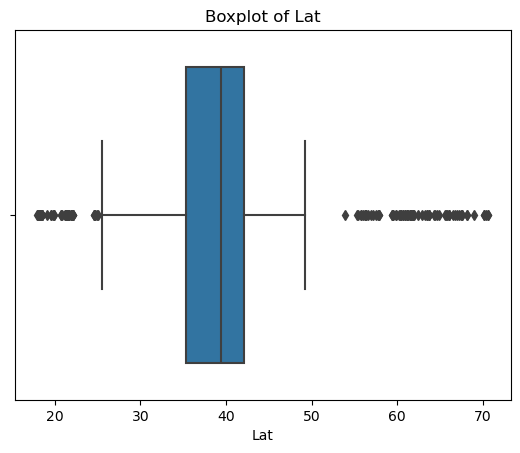

For the `Lat` variable, all observations greater than 52.25 or less than 25.19 are considered outliers.
The count of observations greater than 52.25 is 77.
The count of observations less than 25.19 is 81.


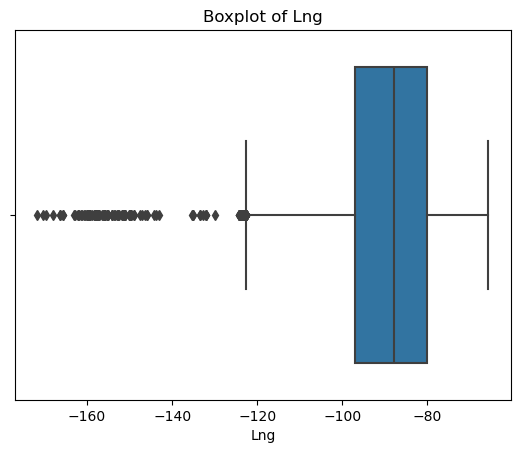

For the `Lng` variable, all observations less than -122.57 are considered outliers.
The count of observations less than -122.57 is 273.


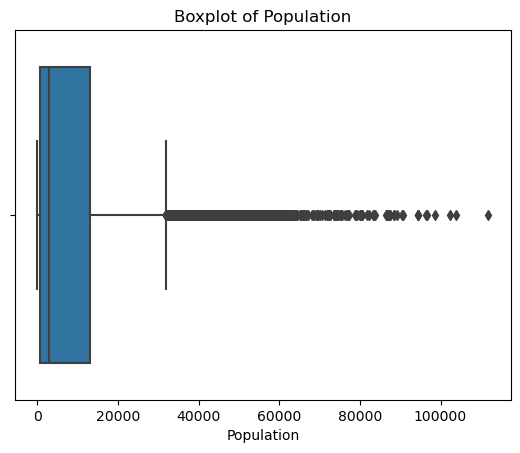

For the `Population` variable, all observations greater than 31813.0 are considered outliers.
The count of observations greater than 31813.0 is 937.


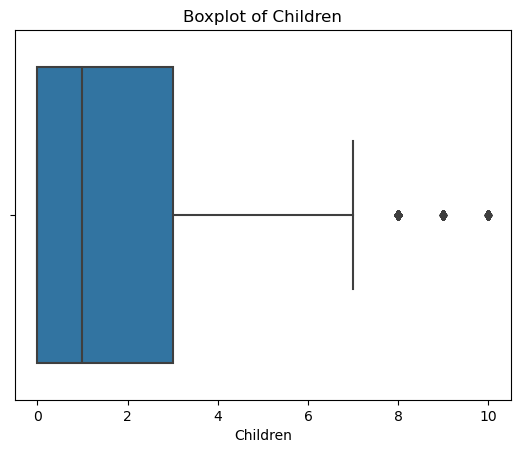

For the `Children` variable, all observations greater than 7.5 are considered outliers.
The count of observations greater than 7.5 is 401.


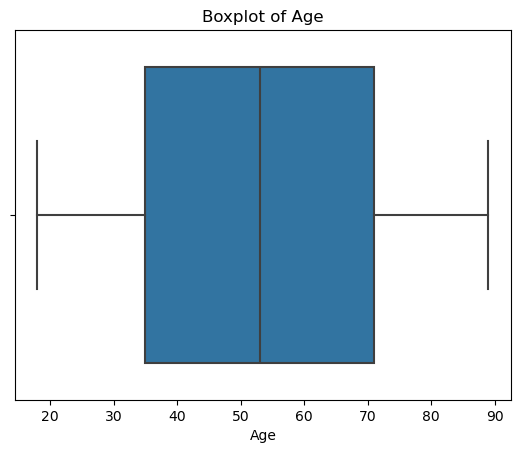

There are no outliers for the `Age` variable.


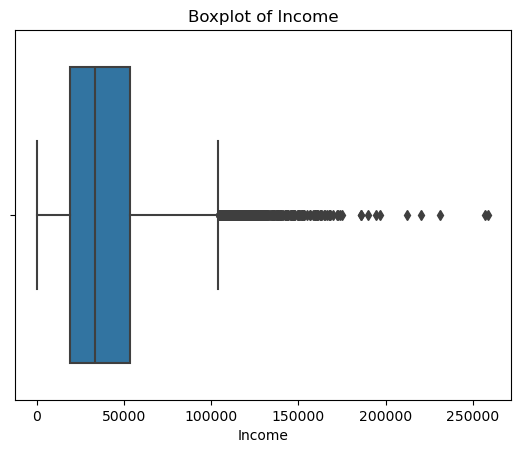

For the `Income` variable, all observations greater than 104278.35 are considered outliers.
The count of observations greater than 104278.35 is 336.


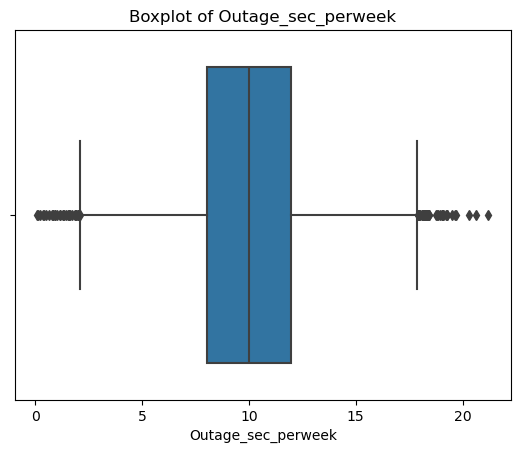

For the `Outage_sec_perweek` variable, all observations greater than 17.9 or less than 2.09 are considered outliers.
The count of observations greater than 17.9 is 43.
The count of observations less than 2.09 is 33.


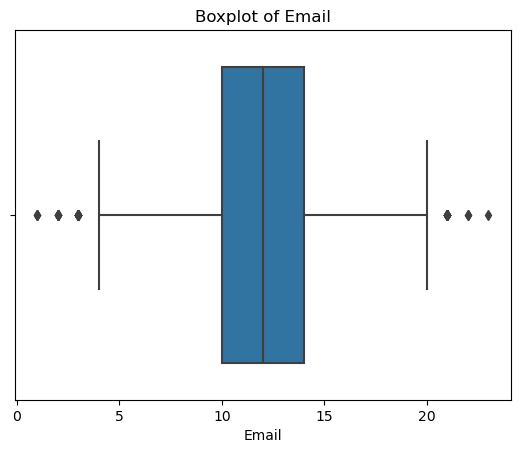

For the `Email` variable, all observations greater than 20.0 or less than 4.0 are considered outliers.
The count of observations greater than 20.0 is 15.
The count of observations less than 4.0 is 23.


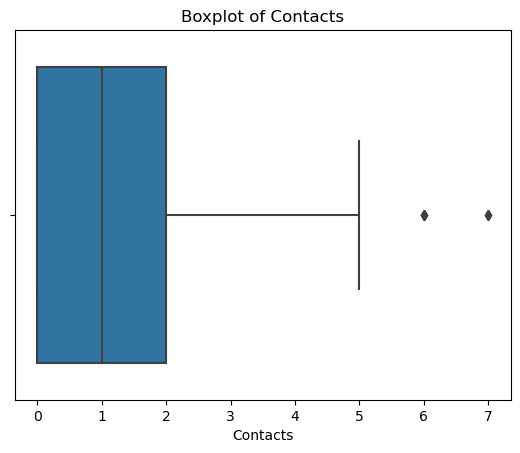

For the `Contacts` variable, all observations greater than 5.0 are considered outliers.
The count of observations greater than 5.0 is 8.


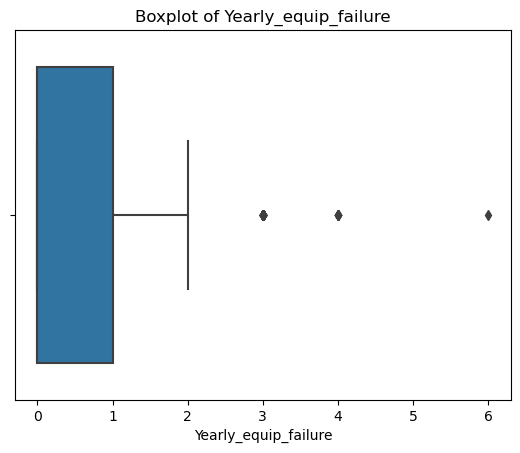

For the `Yearly_equip_failure` variable, all observations greater than 2.5 are considered outliers.
The count of observations greater than 2.5 is 94.


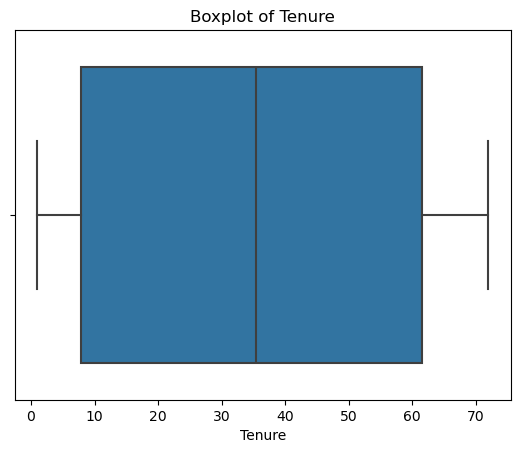

There are no outliers for the `Tenure` variable.


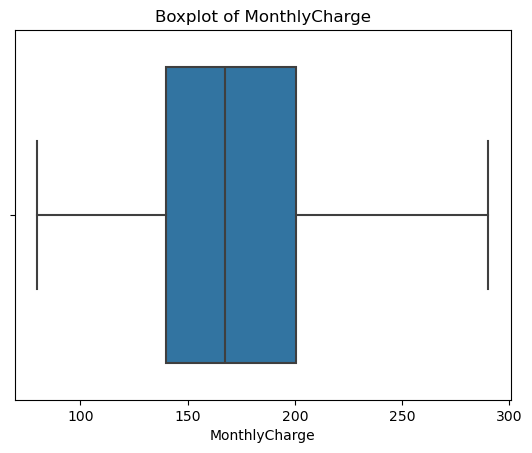

There are no outliers for the `MonthlyCharge` variable.


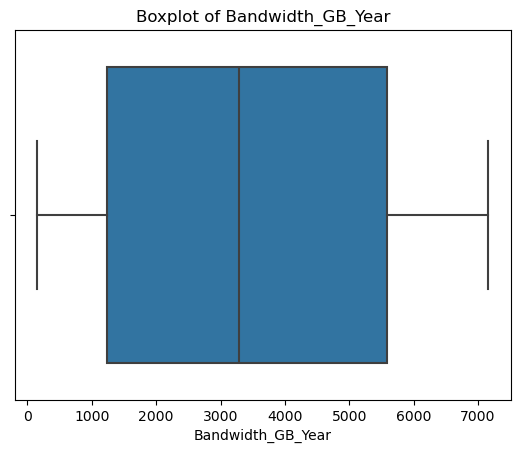

There are no outliers for the `Bandwidth_GB_Year` variable.


In [4]:
## C3 Detection of Outliers

numericVars = df[['Lat', 'Lng', 'Population', 'Children', 'Age', 'Income', 'Outage_sec_perweek', 'Email', 
          'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']]

for col in numericVars:
    boxplotOutliers(df, col)
    

In [5]:
## C3 Treatment of Missing Values

# Since the 'InternetService' variable has 'None' as one of its options,
# it is necessary to impute 'None' 

df['InternetService'].fillna('None', inplace=True)

# Verify that 'None' no longer appears as 'Null'
print('Number of `InternetService` nulls:', df['Tenure'].isnull().sum())

Number of `InternetService` nulls: 0


In [6]:
## C3 Binary Encoding Re-expression of the Thirteen Binary Variables and Type Casting

# Create a list of the columns that will be encoded
binaryList = ['Churn', 'Techie', 'Port_modem', 'Tablet', 'Phone', 
                 'Multiple', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

binaryDict = {'Yes': 1, 'No': 0}

# Run a loop that replaces all 'Yes' with 1 and 'No' with 0 for each column in the list above
for col in binaryList:
    df[col] = df[col].replace(binaryDict)
    
binaryVars = df[['Churn', 'Techie', 'Port_modem', 'Tablet', 'Phone', 
                 'Multiple', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']]

# Type Casting Binary Variables
binaryVars = binaryVars.astype('category')


In [7]:
## C3 One-Hot Encoding Re-expression of the Six Categorical Variables

# Data frame of categorical variables
catVars = df[['Area', 'Marital', 'Gender', 'Contract', 'InternetService', 'PaymentMethod']]

# Create additional data frame from variables being re-expressed
oneHotVars = catVars

# Apply one-hot encoding
oneHotVars = pd.get_dummies(oneHotVars, drop_first = True, dtype = int)  

# Assign Ordinal Variables
ordinalVars = df[['Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8']]

In [8]:
## C3 Scaling

y = df['Bandwidth_GB_Year']
numericVars = numericVars.drop('Bandwidth_GB_Year', axis = 1)
X = pd.concat([numericVars, binaryVars, oneHotVars, ordinalVars], axis = 1)

numeric_cols = ['Lat', 'Lng', 'Population', 'Children', 'Age', 'Income', 'Outage_sec_perweek', 
          'Email', 'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge']

# Split data into four data frames, two training and two testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Standardize numeric features
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])


X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Convert back to DataFrame to retain column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_test.columns)


### C4. Copy of the Cleaned Data Set
See code attached, in D209_PA_MendezD_Task2_Attempt3.ipynb.

In [9]:
## C4 Cleaned Data Set

# Reduced Prepared Data Frame

df_prep = pd.concat([y, X_train_scaled_df], axis = 1)

# df_prep.to_csv('D209_PA_MendezD_Task2_Attempt3.csv', sep = ',', encoding = 'utf-8', index = False)

# Part IV: Analysis
## D. Perform and Report the Data Analysis
### D1. Split Data into Training and Testing Data Sets

In order to prevent data leakage, the data was scaled after being split into training and testing sets (Common Pitfalls and Recommended Practices, n.d.). The code to split the data can be found above in C3, and the code to export those data sets to CSV can be found here.

In [10]:
## D1 The following cells include the annotated code used to export the split the data.
# See code attached, in D209_PA_MendezD_Task2_Attempt3.ipynb

# Create CSVs from above data frames that were split and scaled in C3
# X_train_scaled_df.to_csv('D209_PA_MendezD_Task2_X_train.csv', sep = ',', encoding = 'utf-8', index = False)
# X_test_scaled_df.to_csv('D209_PA_MendezD_Task2_X_test.csv', sep = ',', encoding = 'utf-8', index = False)
# y_train.to_csv('D209_PA_MendezD_Task2_y_train.csv', sep = ',', encoding = 'utf-8', index = False)
# y_test.to_csv('D209_PA_MendezD_Task2_y_test.csv', sep = ',', encoding = 'utf-8', index = False)

### D2. Description of the Analysis Technique 
Since the response variable, `Bandwidth_GB_Year`, is continuous, the method used to perform the prediction analysis is Lasso Regression, also known as L1 regularization (Kumar, 2020). As stated above, the method works by reducing the coefficients of the least influential variables to 0, and the coefficients of the most influential features are given below.

Lasso Regression Coefficients:

| Feature | Coefficient |
| -------- | -------- | 
| Children | 63.593479 |
| Age | -65.593175 |
| Tenure | 2165.323474 |
| MonthlyCharge | 163.203593 |
| Multiple | -43.098888 |
| OnlineSecurity | 56.542587 |
| DeviceProtection | 29.051477 |
| TechSupport | -33.785908 |
| StreamingTV | 58.706185 |
| StreamingMovies | 2.533511 |
| Gender_Male | 57.935030 |
| InternetService_Fiber Optic | -471.790046 |
| InternetService_None | -341.840326 |

As expected, upon applying the  Lasso Regression, some coefficients of less important features were reduced to 0, thus these features are shown to be the least influential. 

Mean Squared Error, which measures the squared error between the true and predicted values, is used for regression models that predict continuous values, thus is an appropriate metric for assessing this Lasso model. The accuracy score, also known as the $R^2$ value, measures the proportion of the variance in the dependent variable that can be explained by the independent variables in the regression model (EITCA Academy, 2023). The accuracy and MSE for the training and testing data are given below.

| Training MSE | Testing MSE | $R^2$ Accuracy |
| -------- | -------- | -------- | 
| 402.54 | 423.96 |  0.9999 |


### D3. Code to Perform the Prediction Analysis
See code attached, in D209_PA_MendezD_Task2_Attempt3.ipynb.

In [11]:
## D3 Code adapted from sci-kit learn documentation

# Fit LassoCV to find the best alpha
lasso_cv = LassoCV(cv = 5, random_state = 42)
lasso_cv.fit(X_train_scaled_df, y_train)


# Predictions
y_pred_train = lasso_cv.predict(X_train_scaled_df)
y_pred_test = lasso_cv.predict(X_test_scaled_df)

In [12]:
## D3

# Coefficients of the features
coeffs = lasso_cv.coef_
coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficients': coeffs})

print("Lasso Regression Coefficients:")
print(coeff_df)

Lasso Regression Coefficients:
                                  Feature  Coefficients
0                                     Lat     -0.000000
1                                     Lng      0.000000
2                              Population      0.000000
3                                Children     63.593479
4                                     Age    -65.593175
5                                  Income     -0.000000
6                      Outage_sec_perweek     -0.000000
7                                   Email     -0.000000
8                                Contacts      0.000000
9                    Yearly_equip_failure     -0.000000
10                                 Tenure   2165.323474
11                          MonthlyCharge    163.203593
12                                  Churn      0.000000
13                                 Techie     -0.000000
14                             Port_modem      0.000000
15                                 Tablet      0.000000
16               

In [13]:
## D3

# Evaluate the model

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f'Training MSE: {train_mse}')
print(f'Testing MSE: {test_mse}')


Training MSE: 402.54285773937585
Testing MSE: 423.9551924051524


In [14]:
## D3

# Evaluate the model

r2_score = lasso_cv.score(X_test_scaled_df, y_test)
print("R^2 Score: ", r2_score)

R^2 Score:  0.9999106383226375


# Part V: Data Summary and Implications
## E. Summary of Data Analysis
### E1. Explanation of MSE of the Model

| Training MSE | Testing MSE | $R^2$ Accuracy |
| -------- | -------- | -------- | 
| 402.54 | 423.96 |  0.9999 |

The MSE of the training data is 402.54, which indicates that, on average, the squared differences between the actual and predicted values on the training data is about 402.54. Given the scale of the variable, this suggests that the model is fitting the data resonably without overfitting. The MSE of the testing data is 423.96, which indicates that, on average, the squared differences between the actual and predicted values on the testing data is about 423.96. This is slightly higher than the training MSE, suggesting that the model is performing reasonably well with unseen data. This suggests that the Lasso model is not overfitting and can make reasonably accurate predictions on new, unseen data. 


The accuracy score of 0.999 suggests that 99.9% of the variability in annual data usage can be explained by variables identified with the Lasso regression model.

### E2. Results and Implications of the Prediction Analysis
As expected, upon applying the Lasso Regression method, some coefficients of less important features were reduced to 0. The features whose coefficients were reduced to zero were shown to be the least influential in the predictions. This suggests that these features do not have any influence in predicting a customer's annual data usage. 

### E3. One Limitation of the Data Analysis
A major limitation with lasso regression is its handling of correlated features, as the method will arbitrarily choose a feature to include in the model (What Is Lasso Regression?, 2024).

### E4. Recommended Course of Action
Based on this model's MSE values and accuracy score, the stakeholders could foreseeably use these features to predict a customer's annual data usage. The recommended course of action would be to further investigate the relationship between the identified variables and annual bandwidth use.

# Part VI: Demonstration
## F. Panopto Video

https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=27473f49-92bc-48f5-ad9a-b1e501198706

## G. Acknowledgement of Web Sources

sklearn.linear_model.LassoCV — scikit-learn 0.24.1 documentation. (n.d.). Scikit-Learn.org. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

Mendez, D (2024, August 21). D209 PA MendezD Task1 Attempt2.

## H. Acknowledgement of Sources

Brownlee, J. (2020, October 11). How to Develop LASSO Regression Models in Python. Machine Learning Mastery. https://machinelearningmastery.com/lasso-regression-with-python/

Common pitfalls and recommended practices. (n.d.). Scikit-Learn. https://scikit-learn.org/stable/common_pitfalls.html

Elleh, F. D209 T2 Building RF in R Churn Data. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=73d810af-b7f7-4ac6-ac4e-b11b00f4384a

EITCA Academy. (2023, August 7). What is the significance of the accuracy score in regression analysis? - EITCA Academy. EITCA Academy. https://eitca.org/artificial-intelligence/eitc-ai-mlp-machine-learning-with-python/regression/regression-training-and-testing/examination-review-regression-training-and-testing/what-is-the-significance-of-the-accuracy-score-in-regression-analysis/


Kumar, D. (2020, September 4). What is LASSO Regression Definition, Examples and Techniques. GreatLearning. https://www.mygreatlearning.com/blog/understanding-of-lasso-regression/

Nagpal, A. (2017, October 13). L1 and L2 Regularization Methods. Medium; Towards Data Science. https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c


sklearn.linear_model.LassoCV — scikit-learn 0.24.1 documentation. (n.d.). Scikit-Learn.org. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

Tibshirani, R. (n.d.). Lasso and Sparsity in Statistics. https://ssc.ca/sites/default/files/data/Members/public/Publications/BookFiles/Book/79-91.pdf

What is lasso regression? | IBM. (2024, January 18). IBM. https://www.ibm.com/topics/lasso-regression
